In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import time

<hr>

## EDA

### Users File Description
================================================================================

User information is in the file "users.dat" and is in the following
format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [2]:
users = pd.read_csv('./ml-1m/users.dat', sep='::', header=None, engine='python')
users.columns= ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [3]:
users.describe()

,UserID,Age,Occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


### Movies File Description
================================================================================

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

In [4]:
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', header=None, engine='python', encoding = "ISO-8859-1")
movies.columns= ['MovieID', 'Title', 'Genres']
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### Ratings File Description
================================================================================

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings


In [5]:
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings.columns= ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings.drop(columns=['Timestamp'], inplace=True)
ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [6]:
ratings.shape

(1000209, 3)

In [69]:
ratings.Rating.describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

### Normalize the ratings by user ratings
- Some users give high ratings to almost all movies, however some give very low ratings. To nullify the effect of user preferences, we can normalize the user ratings by substracting the mean rating for each user.

- To ensure our ratings columns has positive values, we will normalize it to contain rating between 0 and 1

In [7]:
temp_uid = ratings.groupby(by=['UserID']).mean()
temp_uid.head()

,MovieID,Rating
UserID,,
1,1560.547170,4.188679
2,1784.015504,3.713178
3,1787.450980,3.901961
4,1932.000000,4.190476
5,1762.747475,3.146465


In [8]:
ratings1 = pd.merge(ratings, temp_uid['Rating'], on='UserID')
ratings1['rating_normalized'] = ratings1.Rating_x - ratings1.Rating_y

In [9]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [10]:
ratings_normalized = NormalizeData(ratings1['rating_normalized'])
ratings1['rating_normalized'] = ratings_normalized
ratings1 = ratings1.rename(columns={'Rating_x': 'original_rating', 'Rating_y': 'mean_rating_by_user'})

In [11]:
ratings1.head()

,UserID,MovieID,original_rating,mean_rating_by_user,rating_normalized
0,1,1193,5,4.188679,0.619810
1,1,661,3,4.188679,0.356186
2,1,914,3,4.188679,0.356186
3,1,3408,4,4.188679,0.487998
4,1,2355,5,4.188679,0.619810


In [205]:
ratings1.groupby(by=['MovieID']).mean()

,UserID,original_rating,mean_rating_by_user,rating_normalized
MovieID,,,,
1,3053.819933,4.146846,3.667349,0.576072
2,3027.977175,3.201141,3.525284,0.470143
3,2632.156904,3.016736,3.456983,0.454839
4,3268.841176,2.729412,3.428227,0.420756
5,3143.152027,3.006757,3.426533,0.457537
...,...,...,...,...
3948,2063.107889,3.635731,3.608575,0.516448
3949,2289.046053,4.115132,3.566000,0.585251
3950,2123.370370,3.666667,3.614114,0.519796


We can observe from above table how rating_normalized takes care of user preference to always give high ratings or low ratings. Specifically, we can observe row number 3 and 5. Avg. rating for movie 3 is actually high, but after normalization, its lower than movie 5.

In [156]:
temp = ratings1.groupby(by = ['UserID']).mean()
temp.head()

,MovieID,original_rating,mean_rating_by_user,rating_normalized
UserID,,,,
1,1560.547170,4.188679,4.188679,0.512869
2,1784.015504,3.713178,3.713178,0.512869
3,1787.450980,3.901961,3.901961,0.512869
4,1932.000000,4.190476,4.190476,0.512869
5,1762.747475,3.146465,3.146465,0.512869


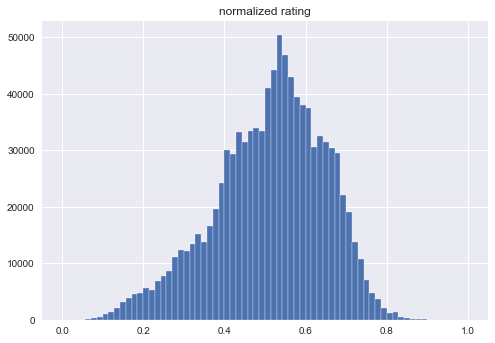

In [174]:
plt.hist(ratings1['rating_normalized'], bins=70)
plt.title('normalized rating')
plt.show()

In [193]:
ratings1['original_rating'].value_counts(normalize=True) * 100

4    34.889808
3    26.114242
5    22.626271
2    10.753453
1     5.616226
Name: original_rating, dtype: float64

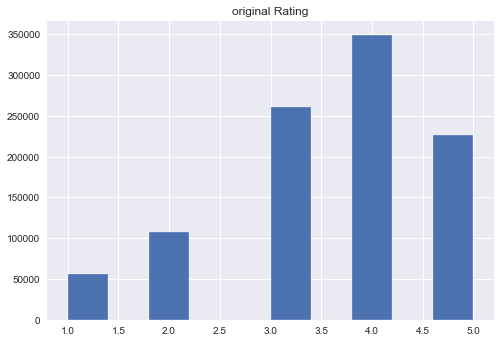

In [190]:
plt.hist(ratings1['original_rating'], bins=10)
plt.title('original Rating')
plt.show()

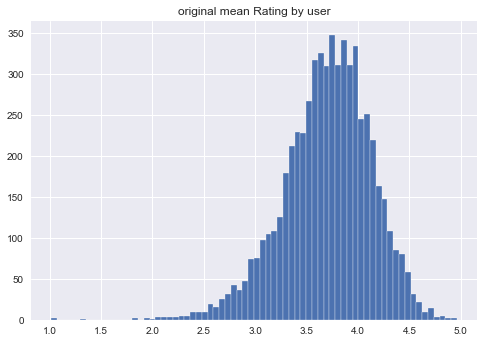

In [179]:
plt.hist(temp['original_rating'], bins=70)
plt.title('original mean Rating by user')
plt.show()

### Ratings per Movie

- Here, we will check what is the distribution of number of ratings for each movie.
- Minimum number of ratings for some movies is only 1. We need to remove such movies while suggesting top movies by genre.

In [200]:
temp = ratings1.groupby(by=['MovieID']).count()
temp.UserID.describe()

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
Name: UserID, dtype: float64

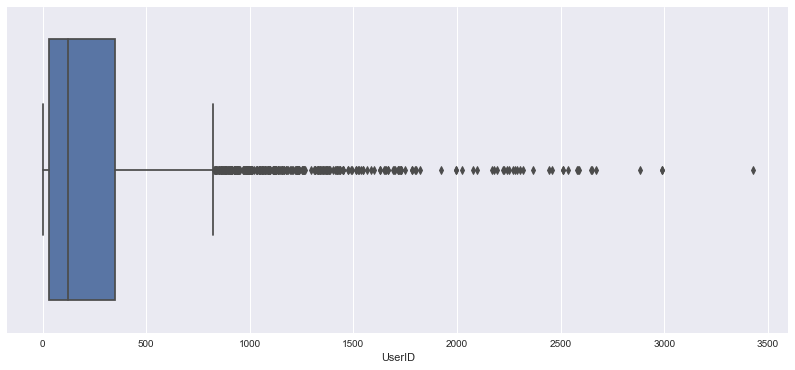

In [201]:
plt.figure(figsize=[14,6])
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=temp["UserID"])

### Ratings per User

- Here, we will check what is the distribution of number of ratings by each user.
- Minimum number of ratings per user are 20 which is good.

In [202]:
temp = ratings1.groupby(by=['UserID']).count()
temp.MovieID.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: MovieID, dtype: float64

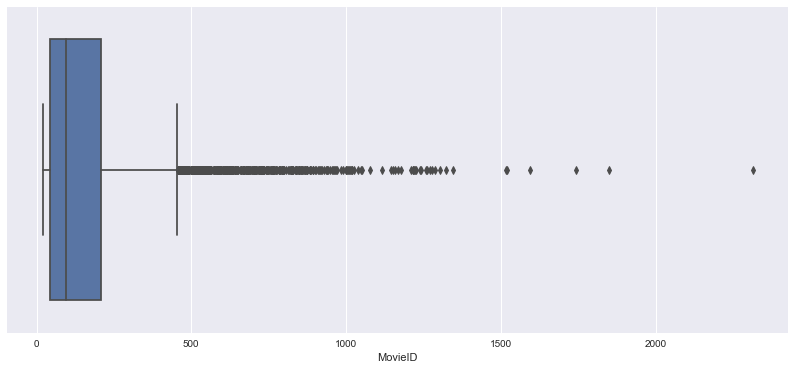

In [203]:
plt.figure(figsize=[14,6])
# sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=temp["MovieID"])
# plt.axvline(x=33, c='r')

In [180]:
movies.shape

(3883, 3)

In [182]:
len(ratings.MovieID.unique())

3706

There are 177 movies that have not been rated by any user.

### Distribution of Genres

In [15]:
all_genres = ['Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']

In [16]:
# ratings1.merge(movies, on='MovieID')
genres_dict = {}

for genre in all_genres:
    count = sum(movies.Genres.str.contains(genre))
    genres_dict[genre]=count

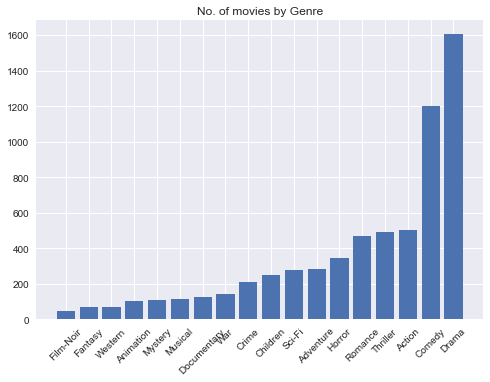

In [17]:
genres_dict = dict(sorted(genres_dict.items(), key=lambda item: item[1]))

plt.bar(genres_dict.keys(), genres_dict.values())
plt.xticks(rotation=45)
plt.title('No. of movies by Genre')
plt.show()

Most of the movies are Drama and Comedy

In [18]:
master_df = pd.merge(ratings1, movies, on='MovieID')

In [19]:
genres_popularity_dict = {}
for genre in all_genres:
    df = master_df[master_df.Genres.str.contains(genre)]
    mean = df.original_rating.mean()
    genres_popularity_dict[genre]=mean

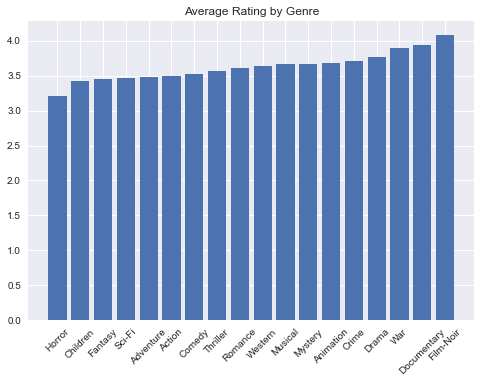

In [20]:
genres_popularity_dict = dict(sorted(genres_popularity_dict.items(), key=lambda item: item[1]))

plt.bar(genres_popularity_dict.keys(), genres_popularity_dict.values())
plt.xticks(rotation=45)
plt.title('Average Rating by Genre')
plt.show()

Film-Noir has highest average rating, but number of such movies are very less compared to other genre. It is followed by Documentary.

<hr>

## Recommending top movies by Genre

<hr>

## Building Recommender System using Collaborative Filtering

### Idea 1

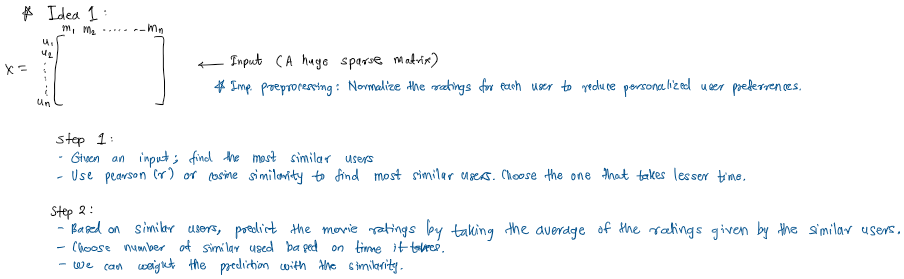

In [21]:
master_df.columns

Index(['UserID', 'MovieID', 'original_rating', 'mean_rating_by_user',
       'rating_normalized', 'Title', 'Genres'],
      dtype='object')

In [22]:
mat = master_df.pivot_table(index='UserID',columns='MovieID',values='rating_normalized').T
mat.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
MovieID,,,,,,,,,,,,,,,,,,,,,
1,0.61981,NaN,NaN,NaN,NaN,0.525864,NaN,0.528041,0.679499,0.62956,...,NaN,0.495125,NaN,NaN,0.695993,NaN,NaN,NaN,NaN,0.436719
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.62956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.300557,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.396229,NaN,NaN,...,NaN,NaN,NaN,NaN,0.432369,0.341127,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.300557,NaN,NaN,NaN,NaN,NaN


In [539]:
mat.shape

(3706, 6040)

In [540]:
mat.iloc[:, 0]

MovieID
1       0.61981
2           NaN
3           NaN
4           NaN
5           NaN
         ...   
3948        NaN
3949        NaN
3950        NaN
3951        NaN
3952        NaN
Name: 1, Length: 3706, dtype: float64

In [541]:
master_df[(master_df.UserID==1) & (master_df.MovieID==1)]

,UserID,MovieID,original_rating,mean_rating_by_user,rating_normalized,Title,Genres
41626,1,1,5,4.188679,0.61981,Toy Story (1995),Animation|Children's|Comedy


In [542]:
mat.corrwith(mat.iloc[:, 0])

C:\Users\Sandi\anaconda3\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\Sandi\anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


UserID
1       1.000000
2       0.416667
3      -0.332182
4       0.333333
5      -0.172516
          ...   
6036   -0.201132
6037   -0.451754
6038         NaN
6039    0.056857
6040   -0.043519
Length: 6040, dtype: float64

In [543]:
# %%timeit
correlation_with_user = mat.corrwith(mat.iloc[:, 2])
corred = pd.DataFrame(correlation_with_user,columns=['Corr'])
corred.dropna(inplace=True)
corred.head()

,Corr
UserID,
1,-0.332182
2,0.236834
3,1.000000
4,0.840168
5,-0.437621


In [544]:
sum(corred.sort_values('Corr',ascending=False)['Corr']==1)

102

In [545]:
corred.sort_values('Corr',ascending=False).head()

,Corr
UserID,
995,1.0
3407,1.0
5587,1.0
3275,1.0
3215,1.0


In [546]:
corred = corred.sort_values('Corr',ascending=False)

In [547]:
pred_df = pd.DataFrame()
for i in range(100):
    pred_df[corred.index[i]] = mat.loc[:, corred.index[i]]
pred_df['mean'] = pred_df.mean(axis=1)

In [548]:
pred_df.sort_values('mean', ascending=False)

,995,3407,5587,3275,3215,3109,992,3040,4783,2871,...,5929,2193,1240,2183,5030,1316,1006,1575,5052,mean
MovieID,,,,,,,,,,,,,,,,,,,,,
1175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.798997
3491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.798997
1780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.798997
2261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.798997
2065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.798997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [549]:
pred_df['mean']

MovieID
1       0.545037
2       0.455694
3       0.579783
4       0.438724
5       0.371293
          ...   
3948    0.487251
3949    0.571586
3950         NaN
3951         NaN
3952    0.227276
Name: mean, Length: 3706, dtype: float64

In [550]:
mat.iloc[:, 2]

MovieID
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
        ..
3948   NaN
3949   NaN
3950   NaN
3951   NaN
3952   NaN
Name: 3, Length: 3706, dtype: float64

In [551]:
# np.sqrt(np.nanmean((np.array(y_true) - np.array(y_pred))**2, ))
np.sqrt(np.nanmean((np.array(mat.iloc[:, 2]) - np.array(pred_df['mean']))**2))

0.10219359786296539

### Checking performance of this algorithm

In [471]:
len(master_df.UserID.unique())

6040

In [482]:
trn_users = np.random.choice(master_df.UserID.unique(), 
                             int(len(master_df.UserID.unique())*0.95), replace=False)
len(trn_users)

5738

In [483]:
trn = master_df.loc[master_df.UserID.isin(trn_users), :]
tst = master_df.loc[~master_df.UserID.isin(trn_users), :]

In [485]:
len(trn), len(tst)

(945764, 54445)

In [508]:
trn_mat = trn.pivot_table(index='UserID',columns='MovieID',values='rating_normalized').T
tst_mat = tst.pivot_table(index='UserID',columns='MovieID',values='rating_normalized').T

In [513]:
len(tst_mat.columns)

302

In [512]:
tst_mat.iloc[:, :]

UserID,2,7,25,57,93,173,178,195,202,204,...,5841,5847,5857,5885,5894,5904,5909,5971,5989,6025
MovieID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,0.517098,NaN,0.659273,0.611826,0.571386,...,0.625738,0.511758,0.469371,NaN,NaN,NaN,NaN,0.571092,0.648104,0.736609
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.395649,NaN,0.571386,...,NaN,NaN,0.601183,NaN,NaN,NaN,NaN,NaN,0.516292,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.480014,NaN,...,NaN,0.248134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.472985
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.472985
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.480014,NaN,...,NaN,0.379946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,NaN,NaN,NaN,NaN,NaN,0.517098,NaN,0.527461,NaN,0.703198,...,0.493926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3949,NaN,NaN,NaN,NaN,NaN,0.517098,NaN,0.659273,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3950,NaN,NaN,NaN,NaN,NaN,0.385286,NaN,0.527461,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [602]:
test_rmse_dict = {}
test_rmse_dict[0] = []
for t in range(0, len(tst_mat.columns)):
    # calculate correlation with each user in training set for user in test set
    correlation_with_user = trn_mat.corrwith(tst_mat.iloc[:, t])
    corred = pd.DataFrame(correlation_with_user,columns=['Corr'])
    corred.dropna(inplace=True)
    corred = corred.sort_values('Corr',ascending=False)
    pred_df = pd.DataFrame()

    # take nearest users and average their rating row-wise to come up with final prediction
    for i in range(10):
        pred_df[corred.index[i]] = trn_mat.loc[:, corred.index[i]]
    pred_df['mean_rating_pred'] = pred_df.mean(axis=1)

    # select only those movies that are there in our test set
    pred_df = pred_df.iloc[pred_df.index.isin(tst_mat.index),]

    # drop movies in our test set which were not available in train set
    idx = tst_mat.index[~tst_mat.index.isin(pred_df.index)]
    tst_mat.drop(idx, axis=0, inplace=True)

    rmse = np.sqrt(np.nanmean((np.array(tst_mat.iloc[:, t]) - np.array(pred_df['mean_rating_pred']))**2))
    test_rmse_dict[0].append(rmse)

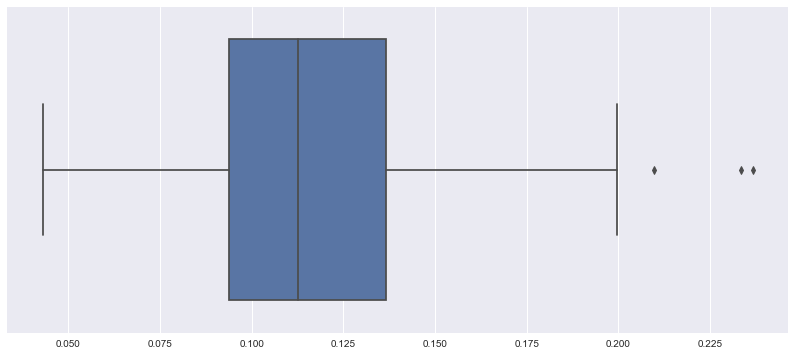

In [614]:
t_start = time.time()
plt.figure(figsize=[14,6])
tips = sns.load_dataset("tips")
ax = sns.boxplot(x=test_rmse_dict[0])
t_end = time.time()

In [615]:
t_end - t_start

0.020943880081176758

In [23]:
test_rmse_dict = {}
t_start = time.time()

for test_set in range(10):
    # randomly select train-test users
    trn_users = np.random.choice(master_df.UserID.unique(), 
                             int(len(master_df.UserID.unique())*0.95), replace=False)
    
    trn = master_df.loc[master_df.UserID.isin(trn_users), :]
    tst = master_df.loc[~master_df.UserID.isin(trn_users), :]
    
    trn_mat = trn.pivot_table(index='UserID',columns='MovieID',values='rating_normalized').T
    tst_mat = tst.pivot_table(index='UserID',columns='MovieID',values='rating_normalized').T
    
    test_rmse_dict[test_set] = []
    
    for t in range(0, len(tst_mat.columns)):
        # calculate correlation with each user in training set for user in test set
        correlation_with_user = trn_mat.corrwith(tst_mat.iloc[:, t])
        corred = pd.DataFrame(correlation_with_user,columns=['Corr'])
        corred.dropna(inplace=True)
        corred = corred.sort_values('Corr',ascending=False)
        pred_df = pd.DataFrame()

        # take nearest users and average their rating row-wise to come up with final prediction
        for i in range(10):
            pred_df[corred.index[i]] = trn_mat.loc[:, corred.index[i]]
        pred_df['mean_rating_pred'] = pred_df.mean(axis=1)

        # select only those movies that are there in our test set
        pred_df = pred_df.iloc[pred_df.index.isin(tst_mat.index),]

        # drop movies in our test set which were not available in train set
        idx = tst_mat.index[~tst_mat.index.isin(pred_df.index)]
        tst_mat.drop(idx, axis=0, inplace=True)

        rmse = np.sqrt(np.nanmean((np.array(tst_mat.iloc[:, t]) - np.array(pred_df['mean_rating_pred']))**2))
        test_rmse_dict[test_set].append(rmse)
    
    print(test_set)
t_end = time.time()

0
1
2
3
4
5
6
7
8
9


In [24]:
t_end - t_start

5977.76284122467

In [25]:
test_result = pd.DataFrame.from_dict(test_rmse_dict)
test_result.to_

,0,1,2,3,4,5,6,7,8,9
0,0.068333,0.064901,0.121028,0.072326,0.113255,0.149305,0.098353,0.081348,0.186989,0.121685
1,0.122833,0.091236,0.136311,0.117252,0.110442,0.145961,0.146597,0.070731,0.098818,0.183099
2,0.132331,0.112253,0.126431,0.119929,0.170167,0.108425,0.082607,0.148127,0.041859,0.119395
3,0.092605,0.173837,0.122103,0.109551,0.118721,0.115615,0.123464,0.078524,0.100161,0.125515
4,0.119438,0.125963,0.222757,0.082308,0.095367,0.101280,0.109637,0.128315,0.112713,0.145477
...,...,...,...,...,...,...,...,...,...,...
297,0.175264,0.123390,0.123060,0.167411,0.083233,0.095966,0.121565,0.128302,0.103297,0.111861
298,0.131979,0.143497,0.124321,0.096188,0.200274,0.172731,0.132132,0.143675,0.118463,0.135873
299,0.136661,0.116780,0.155609,0.086889,0.161828,0.128576,0.145200,0.097983,0.125781,0.101452
300,0.067391,0.129851,0.106062,0.075716,0.132441,0.059046,0.141825,0.105528,0.090605,0.201568


### Predicting movie recommendations for new user